# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях». 
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Бизнес-метрика и другие данные
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:
категория A: за ночь — 1 000, разовое обслуживание — 400;
категория B: за ночь — 800, разовое обслуживание — 350;
категория C: за ночь — 600, разовое обслуживание — 350;
категория D: за ночь — 550, разовое обслуживание — 150;
категория E: за ночь — 500, разовое обслуживание — 150;
категория F: за ночь — 450, разовое обслуживание — 150;
категория G: за ночь — 350, разовое обслуживание — 150.
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Описание данных
В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
id — номер записи;
adults  — количество взрослых постояльцев;
arrival_date_year — год заезда;
arrival_date_month — месяц заезда;
arrival_date_week_number — неделя заезда;
arrival_date_day_of_month — день заезда;
babies — количество младенцев;
booking_changes — количество изменений параметров заказа;
children — количество детей от 3 до 14 лет;
country — гражданство постояльца;
customer_type  — тип заказчика:
  
Contract — договор с юридическим лицом;
Group — групповой заезд;
Transient — не связано с договором или групповым заездом;
Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
days_in_waiting_list — сколько дней заказ ожидал подтверждения;
distribution_channel — канал дистрибуции заказа;
is_canceled — отмена заказа;
is_repeated_guest — признак того, что гость бронирует номер второй раз;
lead_time — количество дней между датой бронирования и датой прибытия;
meal — опции заказа:
  
SC — нет дополнительных опций;
BB — включён завтрак;
HB — включён завтрак и обед;
FB — включён завтрак, обед и ужин.
previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
previous_cancellations — количество отменённых заказов у клиента;
required_car_parking_spaces — необходимость места для автомобиля;
reserved_room_type  — тип забронированной комнаты;
stays_in_weekend_nights — количество ночей в выходные дни;
stays_in_week_nights — количество ночей в будние дни;
total_nights — общее количество ночей;
total_of_special_requests — количество специальных отметок.

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import plotly.express as px
from sklearn.model_selection import cross_val_score

In [2]:
try:
    hotel_train = pd.read_csv('hotel_train.csv')
except:
    hotel_train = pd.read_csv('/datasets/hotel_train.csv')

In [3]:
try:
    hotel_test = pd.read_csv('hotel_test.csv')
except:
    hotel_test = pd.read_csv('/datasets/hotel_test.csv')

### Шаг 2. Предобработка и исследовательский анализ данных

In [4]:
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [5]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [7]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [8]:
pd.DataFrame(round(hotel_train.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
id,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000


In [9]:
hotel_train.duplicated().sum()

0

In [10]:
hotel_train.drop(['id'], axis=1).duplicated().sum()

21377

In [11]:
hotel_test.duplicated().sum()

0

In [12]:
hotel_test.drop(['id'], axis=1).duplicated().sum()

7717

Пропусков и дубликатов в исходных данных нет. Дубликаты после удаления id связаны, вероятнее всего с одновременными приездами групп людей в однотипные номера (точной даты и времени приезда в данных нет) 

In [13]:
hotel_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [14]:
hotel_train.groupby(by=['babies'])['id'].count()

babies
0.0     64777
1.0       447
2.0         3
9.0         1
10.0        1
Name: id, dtype: int64

In [15]:
hotel_train = hotel_train.drop(hotel_train.loc[hotel_train['babies']>1].index)

In [16]:
hotel_train.groupby(by=['babies'])['id'].count()

babies
0.0    64777
1.0      447
Name: id, dtype: int64

In [17]:
hotel_train.groupby(by=['children'])['id'].count()

children
0.0    61707
1.0     2165
2.0     1336
3.0       16
Name: id, dtype: int64

Большая часть гостей приезжает без детей и младенцев. Два бронирования с 9 и 10 младенцами (чаще всего - дети до 2 лет) скорее всего организованный выезд группы детей.

In [18]:
hotel_train.groupby(by=['customer_type'])['id'].count()

customer_type
Contract            2746
Group                287
Transient          45489
Transient-Party    16702
Name: id, dtype: int64

Большая часть гостей - индивидуальные путешественники.

In [19]:
hotel_train.groupby(by=['reserved_room_type'])['id'].count()

reserved_room_type
A                   50499
B                     860
C                     227
D                    9385
E                    2448
F                    1213
G                     592
Name: id, dtype: int64

Чаще всего гости бронируют самые дорогие номера.

In [20]:
hotel_train.groupby(by=['arrival_date_month'])['id'].count().sort_values(ascending=False)

arrival_date_month
October      9254
September    8781
August       6678
November     5760
July         5717
December     5497
April        4804
May          4677
June         4659
March        4148
February     3358
January      1891
Name: id, dtype: int64

Загруженность отеля неравномерна в течении года: максимальная загрузка в октябре, сентябре и августе, минимальная - январь, февраль, март.

In [21]:
hotel_train.groupby(by=['meal'])['id'].count()

meal
BB           51694
FB             451
HB            7290
SC             515
SC            5274
Name: id, dtype: int64

In [22]:
hotel_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [23]:
hotel_train['meal'] = hotel_train['meal'].str.strip()
hotel_test['meal'] = hotel_test['meal'].str.strip()

In [24]:
hotel_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [25]:
hotel_train.groupby(by=['meal'])['id'].count()

meal
BB    51694
FB      451
HB     7290
SC     5789
Name: id, dtype: int64

Большая часть гостей предпочитает только завтракать в отеле, но часть там и ужинает. Менее 10% гостей ест вне отеля.   

In [26]:
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [27]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()

In [28]:
hotel_train.groupby(by=['country'])['id'].count().sort_values(ascending=False).head(10)

country
PRT    28829
FRA     5974
GBR     5107
ESP     4900
DEU     3887
ITA     2327
IRL     1445
BEL     1245
NLD     1166
BRA     1088
Name: id, dtype: int64

География гостей достаточно широка: основная часть гостей из Португалии, также много из Франции, Великобритании, Испании и Германии; на 10 месте - Бразилия. Вероятнее всего, отель на португальских Азорских островах.

In [29]:
hotel_train.groupby(by=['distribution_channel'])['id'].count()

distribution_channel
Corporate     3822
Direct        6852
GDS             99
TA/TO        54451
Name: id, dtype: int64

Подавляющее число гостей бронирует отель через турагентства.

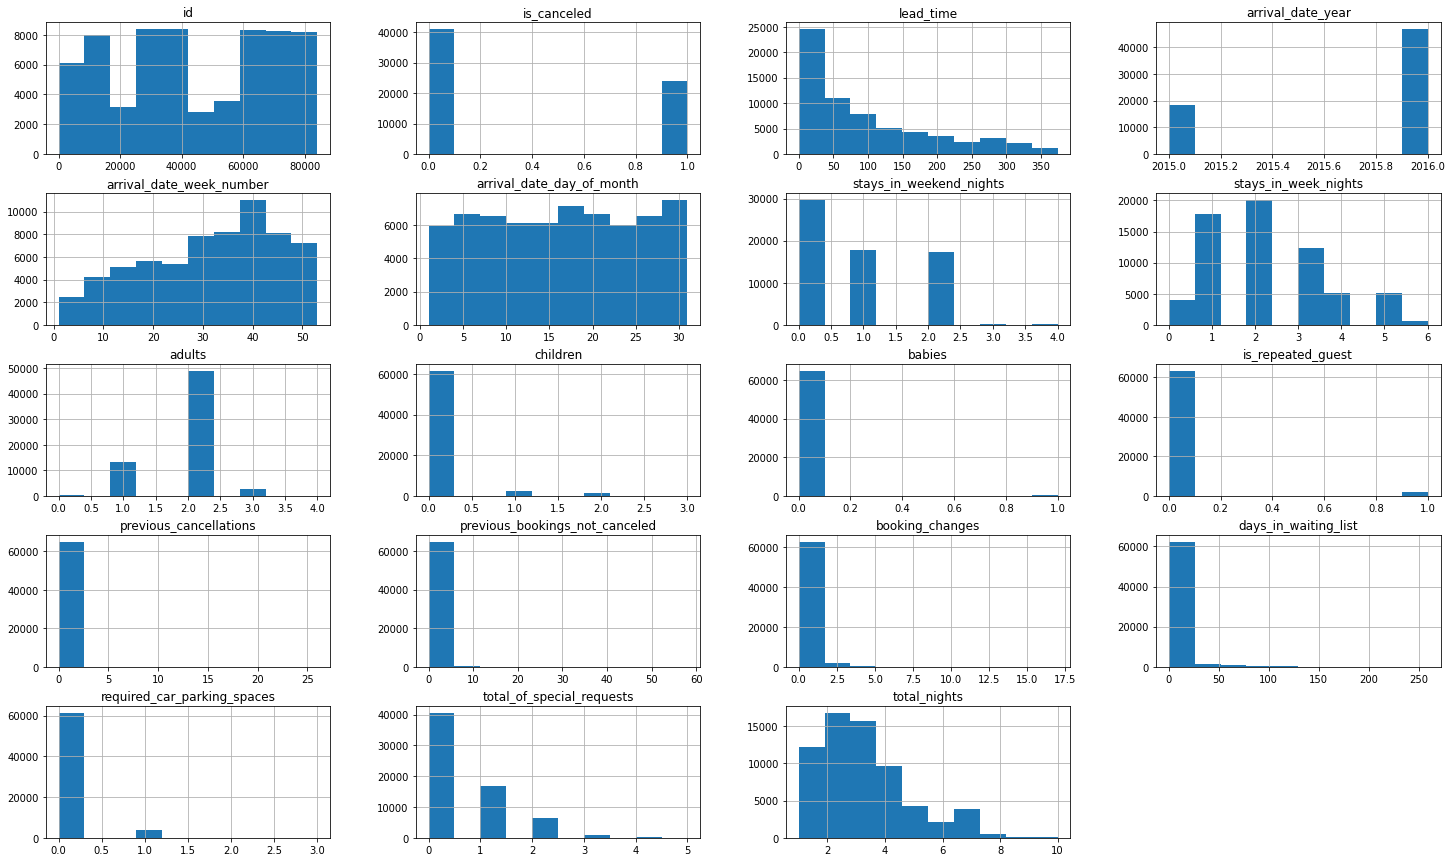

In [30]:
hotel_train.hist(figsize = (25,15));

In [31]:
most_country = ['PRT', 'FRA', 'GBR', 'ESP', 'DEU','ITA', 'IRL', 'BEL', 'NLD', 'BRA']
hotel_train.loc[~hotel_train['country'].isin(most_country), 'country'] = 'other'

In [32]:
most_country = ['PRT', 'FRA', 'GBR', 'ESP', 'DEU','ITA', 'IRL', 'BEL', 'NLD', 'BRA']
hotel_test.loc[~hotel_test['country'].isin(most_country), 'country'] = 'other'

Для удобства анализа сокращаем количество стран приезда до 10 основных.

In [33]:
hotel_train['country'].nunique()

11

In [34]:
hotel_test['country'].nunique()

11

In [35]:
hotel_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [36]:
duplicates = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
names = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
hotel_train['arrival_date_month'] = hotel_train['arrival_date_month'].replace(duplicates, names)

In [37]:
duplicates = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
names = [1, 2, 3, 4, 5, 6, 7, 8]
hotel_test['arrival_date_month'] = hotel_test['arrival_date_month'].replace(duplicates, names)

Заменяем наименования месяцев на порядковые значения.

In [38]:
hotel_train['total_nights'].sum() - (hotel_train['stays_in_week_nights'].sum() + hotel_train['stays_in_weekend_nights'].sum())

0

In [39]:
hotel_train.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1)
hotel_test.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,1,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,1,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,1,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,1,1,1,1.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,1,1,1,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164.0,2017,8,35,31,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,6
32408,97900,0,21.0,2017,8,35,30,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,2,7
32409,97901,0,23.0,2017,8,35,30,2.0,0.0,0.0,...,0,0,0,A,0,0,Transient,0,0,7
32410,97902,0,34.0,2017,8,35,31,2.0,0.0,0.0,...,0,0,0,D,0,0,Transient,0,4,7


##  Промежуточный вывод 1 

Для анализа представлены данные бронирований отеля за часть 2015, 2016 и часть 2017 годов. Данные корректны, минимальные ошибки (возникшие или при вводе или выгрузке данных) легко устранимы. При анализе данных выявлено: основная часть гостей - взрослые без детей, чаще из Португалии и других стран западной Европы, номера бронируются через турагентства, большая часть гостей пользуется услугами отеля в формате bed&breakfast. В загрузке отеля есть сезонность - пик осенью, спад зимой. У отеля мало лояльных клиентов - отмены бронирований происходят в 37% случаев, менее 3% - гости, возвращающиеся в отель. Однако, медианное время предварительного бронирования 3 месяца и большая часть гостей бронирует номера верхней ценовой категории.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

В связи с достаточно высокой долей отмен бронирований (38%) и отсутствием предоплаты, каждая отмена приводит к убытку в размере стоимости номера за ночь и стоимости однократной уборки номера. Исходя из этого, нужно на этапе бронирования выявить высокий риск отмены и включить в условия бронирования предоплату в размере 80% стоимости номера за ночь и стоимости однократной уборки номера. Для этого нужно подобрать и обучить модель на данных 2015-16 годов для выполнения бинарной задачи классификации, подобрать метрику для оценки корректности модели и на данных 2017 года выполнить тест модели и эффект от её работы. 

In [40]:
hotel_test_ohe = pd.get_dummies(hotel_test, drop_first=True)
hotel_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  int64  
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  is_repeated_guest               

In [41]:
hotel_test_pr = hotel_test

In [42]:
def get_night_cost(value):
    if value == 'A':
        return 1000
    if value == 'B':
        return 800
    if value == 'C':
        return 600
    if value == 'D':
        return 550
    if value == 'E':
        return 500
    if value == 'F':
        return 450
    if value == 'G':
        return 350

hotel_test_pr['room_cost'] = hotel_test_pr['reserved_room_type'].apply(get_night_cost)
    

In [43]:
def get_service_cost(value):
    if value == 'A':
        return 400
    if value == 'B':
        return 350
    if value == 'C':
        return 350
    if value == 'D':
        return 150
    if value == 'E':
        return 150
    if value == 'F':
        return 150
    if value == 'G':
        return 150

hotel_test_pr['service_cost'] = hotel_test_pr['reserved_room_type'].apply(get_service_cost)
    

In [44]:
def get_season_coeff(value):
    if value in (12, 1, 2):
        return 1
    if value in (3, 4, 5, 9, 10, 11):
        return 1.2
    if value in (6, 7, 8):
        return 1.4
    
hotel_test_pr['season_coeff'] = hotel_test_pr['arrival_date_month'].apply(get_season_coeff)

In [45]:
def total_cost_pre (row):
    if row['is_canceled'] == 1:
        result = 0 - ((row['room_cost'] * row['season_coeff']) + row['service_cost'])
    if row['is_canceled'] == 0:
        result = (row['room_cost'] * row['total_nights'] * row['season_coeff']) - \
        ((1 + row['total_nights'] // 2) * row['service_cost'])         
    return result

hotel_test_pr['total_cost_pre'] = hotel_test_pr.apply(total_cost_pre, axis=1)


In [46]:
print('Выручка отеля до внедрения классификатора: ', hotel_test_pr['total_cost_pre'].sum())

Выручка отеля до внедрения классификатора:  32582920.0


In [47]:
print('Убыток отеля из-за отмен бронирований:', hotel_test_pr.loc[hotel_test_pr['is_canceled'] == 1, 'total_cost_pre'].sum())

Убыток отеля из-за отмен бронирований: -18041560.0


## Промежуточный вывод 2

На основании представленных данных за 8 месяцев 2017г подсчитана общая выручка и потери вследствии отмен бронирований. Выручка: 32582920.0 и потери 18041560.0

### Шаг 4. Разработка модели ML

В качестве оценки качества моделей применена метрика F1, как достаточно сбалансированная, что бы избежать большого количества ложноположительных и ложноотрицательных ответов классификатора. Большое количество ложноположительных ответов модели конечно снизит затраты на отменённые брони, но, скорее всего, серьёзно повлияет на потребительское поведение клиентов (предоплата). Большое количество ложноотрицательных ответов нивелирует ожидаемый финансовый результат.

In [48]:
hotel_train_ohe = pd.get_dummies(hotel_train, drop_first=True)
hotel_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65224 entries, 0 to 65228
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65224 non-null  int64  
 1   is_canceled                     65224 non-null  int64  
 2   lead_time                       65224 non-null  float64
 3   arrival_date_year               65224 non-null  int64  
 4   arrival_date_month              65224 non-null  int64  
 5   arrival_date_week_number        65224 non-null  int64  
 6   arrival_date_day_of_month       65224 non-null  int64  
 7   stays_in_weekend_nights         65224 non-null  int64  
 8   stays_in_week_nights            65224 non-null  int64  
 9   adults                          65224 non-null  float64
 10  children                        65224 non-null  float64
 11  babies                          65224 non-null  float64
 12  is_repeated_guest               

In [49]:
print(hotel_train_ohe.drop(['id'], axis=1).corr())

                                is_canceled  lead_time  arrival_date_year  \
is_canceled                        1.000000   0.328132          -0.030852   
lead_time                          0.328132   1.000000          -0.022981   
arrival_date_year                 -0.030852  -0.022981           1.000000   
arrival_date_month                 0.014630   0.094863          -0.398062   
arrival_date_week_number           0.012870   0.091603          -0.388002   
arrival_date_day_of_month         -0.001933  -0.010236           0.009741   
stays_in_weekend_nights           -0.013756   0.047009          -0.006431   
stays_in_week_nights               0.010666   0.172644           0.013746   
adults                             0.045151   0.119606           0.029060   
children                          -0.017760  -0.056367           0.052611   
babies                            -0.031888  -0.026641          -0.007197   
is_repeated_guest                 -0.040252  -0.089431          -0.005961   

In [50]:
y_train = hotel_train_ohe['is_canceled']
x_train = hotel_train_ohe.drop(['id', 'is_canceled', 'arrival_date_day_of_month', 'reserved_room_type_G' ] , axis=1)

Убрал из списка фичей ненужную колонку 'id' и признаки, где индекс корелляции с целевым признаком менее 0.01

In [51]:
y_train.mean()

0.36863731141910955

In [52]:
numeric = ['lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'total_nights']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])


Стандартизация численных значений.

In [53]:
clf_1 = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
params_1 = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 12, 2)}
search_1 = GridSearchCV(clf_1, params_1, cv=5, n_jobs=-1, scoring='f1')
search_1.fit(x_train, y_train)
best_clf_1 = search_1.best_estimator_

Подбор параметром для модели DecisionTreeClassifier

In [54]:
best_clf_1

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, random_state=12345)

In [55]:
search_1.best_score_

0.6074711250569178

Лучший показатель F1 на этой модели

In [ ]:
clf_2 = RandomForestClassifier(random_state=12345, class_weight='balanced')
params_2 = {'criterion': ['gini', 'entropy'], 'n_estimators': range (10, 200, 10), 'max_depth': range(1, 12, 2)}
search_2 = GridSearchCV(clf_2, params_2, cv=5, n_jobs=-1, scoring='f1')
search_2.fit(x_train, y_train)
best_clf_2 = search_2.best_estimator_

Подбор параметром для модели RandomForestClassifier

In [ ]:
best_clf_2

In [ ]:
search_2.best_score_

Лучший показатель F1 на этой модели

In [ ]:
clf_3 = LogisticRegression(random_state=12345, class_weight='balanced')
params_3 = {'max_iter': range (500, 5000, 500)}
search_3 = GridSearchCV(clf_3, params_3, cv=5, n_jobs=-1, scoring='f1')
search_3.fit(x_train, y_train)
best_clf_3 = search_3.best_estimator_

Подбор параметром для модели LogisticRegression

In [ ]:
best_clf_3

In [ ]:
search_3.best_score_

Лучший показатель F1 на этой модели

In [ ]:
x_test = hotel_test_ohe.drop(['id', 'is_canceled', 'arrival_date_day_of_month', 'reserved_room_type_G'] , axis=1)

In [ ]:
y_test = hotel_test_ohe['is_canceled']

In [ ]:
is_canceled_pred = best_clf_2.predict(x_test)

подготовка тестовой выборки

In [ ]:
scores = cross_val_score(best_clf_2, x_test, y_test, cv=5, scoring='f1') 
final_score = scores.sum()/len(scores)
print('Средняя оценка качества модели:', final_score)

In [ ]:
is_canceled_pred = pd.Series(is_canceled_pred)

In [ ]:
hotel_test_pr['is_canceled_pred'] = is_canceled_pred[hotel_test_pr.index]

In [ ]:
hotel_test_pr.info()

In [ ]:
hotel_test_pr['is_canceled_pred'].mean()

In [ ]:
def profit_clf (row):
    if row['is_canceled_pred'] == 1:
        if row['is_canceled'] == 1:
            return row['total_cost_pre'] * 0.2
        elif row['is_canceled'] == 0:
            return row['total_cost_pre']
    elif row['is_canceled_pred'] == 0:
        return row['total_cost_pre']

hotel_test_pr['total_cost_past'] = hotel_test_pr.apply(profit_clf, axis=1)    

In [ ]:
hotel_test_pr

Подсчёт выручки отеля на тестовой выборке с учётом обученного классификатора

In [ ]:
print('Выручка отеля после внедрения классификатора: ', hotel_test_pr['total_cost_past'].sum())

In [ ]:
print('Убыток отеля из-за отмен бронирований: ', hotel_test_pr.loc[hotel_test_pr['is_canceled'] == 1, 'total_cost_past'].sum())

In [ ]:
print('Финансовый эффект применения классификатора: ', hotel_test_pr['total_cost_past'].sum() - hotel_test_pr['total_cost_pre'].sum())

## Промежуточный вывод 3

Для решения задачи были подобраны и обучены 3 модели: DecisionTreeClassifier, RandomForestClassifier и LogisticRegression. В качестве оценки качества моделей применена метрика F1, как достаточно сбалансированная, что бы избежать большого количества ложноположительных и ложноотрицательных ответов классификатора.

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [ ]:
imp = pd.DataFrame(
    best_clf_1.feature_importances_,
    index=x_train.columns,
    columns=["importance"]
)

fig = px.histogram(
    imp,
    x=["importance"],
    y=x_train.columns
)

fig.show()

In [ ]:
print(hotel_train_ohe.drop(['id'], axis=1).corr())

Исходя из значимости признаков, выявленных при постороении DecisionTreeClassifier, "ненадёжный" клиент - это житель Португалии, забронировавший номер индивидуально через турагентство, очень заблаговременно, без запроса парковки и особых условий, без изменений в бронировании, ранее он уже отменял бронирования в этом отеле.

### Шаг 6. Напишите общий вывод

Для снижения издержек из-за отмен бронирований была поставлена задача построить и обучить модель - бинарный классификатор для выявления клиентов высокого риска на этапе бронирования и запроса частичной предоплаты. Были подобраны и обучены 3 модели: DecisionTreeClassifier, RandomForestClassifier и LogisticRegression. При незначительной разнице в метрике F1 у этих моделей предсказания на тестовой выборке значительно различаются. DecisionTreeClassifier классифицирует 56% клиентов как "ненадёжных", LogisticRegression так классифицирует 100% клиентов, RandomForestClassifier отмечает "ненадёжными" 30% клиентов. На мой взгляд, меньшее влияние на потребительское поведение будет оказывать модель с меньшим запросом предоплаты. На тестовой выборке расчитана выручка отеля до применения классификатора и после. Финансовый эффект применения классификатора составил 7193728. С учётом затрат на разработку системы прогнозирования 400000, выгода очевидна. Для понимания более полного эффекта от внедрения этой системы, вероятнее всего, потребуется маркетинговые исследования поведения клиентов, столкнувшихся с необходимостью частичной предоплаты. 